# Реализация класса Dataset для генерации данных для обучения модели классификации ортогонального поворота текста (OCR)
- Автор: Кирилл Киселев
- Дата начала: 22.06.2022
- Цель: реализовать кастомный датасет, который берет фотографию из папки, вырезает из нее кусок, поворачивает, размечает и возвращает размеченную картинку.

## 1. Загруза необходимых библиотек

In [16]:
from tqdm import tqdm
import torch
import pandas as pd
import numpy as np
import os
import shutil

from PIL import Image
from pathlib import Path
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [4]:
torch.cuda.is_available()

False

## 2. Глобальные перменные

In [20]:
DATA_PATH = '/home/kirillk/datasets/OCR/ocr_data_generator/'

In [21]:
data_list = os.listdir(DATA_PATH)
data_list

['010.jpg',
 '003.jpg',
 '004.jpg',
 '007.jpg',
 '009.jpg',
 '008.jpg',
 '005.jpg',
 '002.jpg',
 '001.jpg',
 '006.jpg']

## 3. Необходимые функции

In [26]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

## 4. Предварительные исследования

In [27]:
orig_img = Image.open(Path(DATA_PATH + data_list[0]))

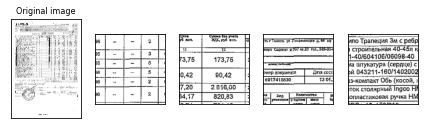

In [82]:
cropper = T.RandomCrop(size=(500, 500))
crops = [cropper(orig_img) for _ in range(4)]
plot(crops)

In [83]:
for crop in crops:
    gray_crop = T.Grayscale()(crop)
    print(ToTensor()(crop).numpy().mean())

0.8926132
0.8541
0.8083601
0.75412


In [74]:
gray_crop = T.Grayscale()(crops[0])

In [75]:
gray_tensor = ToTensor()(gray_crop).numpy()
gray_tensor.mean()

0.99038327

In [72]:
gray_tensor.mean() < 0.9

True

### Вывод:
Среднее значение полностью белого кропа равно 1
Предварительный порог белог 0.9

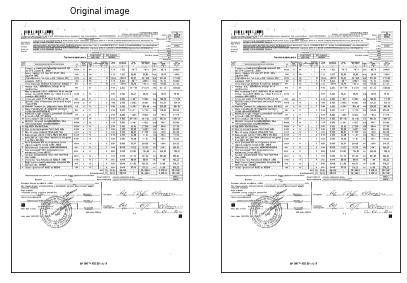

In [34]:
gray_img = T.Grayscale()(orig_img)
plot([gray_img], cmap='gray')

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label